In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
#import src.visuals as vs
from matplotlib import pyplot as plt
#from IPython.display import display # Allows the use of display() for DataFrames
from scipy.stats import norm
# Import supplementary visualizations code visuals.py
#import lightgbm as lgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#from lightgbm.sklearn import LGBMClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,fbeta_score,make_scorer,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import pickle

from sklearn.externals import joblib
seed = 3

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
bc = pd.read_csv('data/branded_content_events.csv')
ai = pd.read_csv('data/app_install_events.csv')
ck = pd.read_csv('data/checkout_events.csv')

### data quality check

In [ ]:
bc.info(null_counts=True)

In [ ]:
bc['uid'].nunique()

In [ ]:
bc = bc.drop_duplicates()

In [ ]:
bc.rename(columns={'event_time': 'ad_event_time'}, inplace=True)

In [ ]:
bc.shape

### EDA

In [ ]:
bc['ad_event_time'] = pd.to_datetime(bc['ad_event_time'],unit='s')
bc['ad_event_date'] = bc['ad_event_time'].dt.date

In [ ]:
bc.head()

In [ ]:
bc['ad_dow'] = bc['ad_event_time'].dt.dayofweek

In [ ]:
bc['ad_hour'] = bc['ad_event_time'].dt.hour

In [ ]:
ad_cnt = bc.groupby('ad_event_date')['uid'].count().reset_index().sort_values(by='ad_event_date')

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(ad_cnt['ad_event_date'],ad_cnt['uid'],'o--')
ax.set_title('ads count')
ax.set_xlabel('ads date')
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Number of ads')

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="ad_dow", data=bc)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="ad_hour", data=bc)

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="platform", data=bc)

In [ ]:
top_ten_list = bc['campaign_name'].value_counts().nlargest(10).index.tolist()

In [ ]:
bc['campaign_name_std'] = np.where(bc['campaign_name'].isin(top_ten_list),bc['campaign_name'],'non_top_ten')

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="campaign_name_std", data=bc)

In [ ]:
bc['campaign_name'].nunique()

In [ ]:
### App Install

In [ ]:
ai.info(null_counts=True)

In [ ]:
ai = ai.drop_duplicates()

In [ ]:
ai.rename(columns={'event_time': 'ai_event_time'}, inplace=True)

In [ ]:
ai.info()

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="source", data=ai)

In [ ]:
ai['ai_event_time'] = pd.to_datetime(ai['ai_event_time'],unit='s')
ai['ai_event_date'] = ai['ai_event_time'].dt.date
ai['ai_dow'] = ai['ai_event_time'].dt.dayofweek
ai['ai_hour'] = ai['ai_event_time'].dt.hour

In [ ]:
ai_cnt = ai.groupby('ai_event_date').size().to_frame('ai_cnt').reset_index().sort_values(by='ai_event_date')

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(ai_cnt['ai_event_date'],ai_cnt['ai_cnt'],'o--')
ax.set_title('install count')
ax.set_xlabel('install date')
fig.autofmt_xdate(rotation=90)
ax.set_ylabel('Number of ads')

In [ ]:
ai_uid_isnull = ai[ai['uid'].isnull()]
ai_uid_notnull = ai[ai['uid'].notnull()]

In [ ]:
ai_uid_isnull.describe()

In [ ]:
ai_uid_notnull.describe()

In [ ]:
ai_uid_notnull['article_id'] = ai_uid_notnull['article_id'].astype(int)

In [ ]:
ai_uid_notnull['article_id'].value_counts()

In [ ]:
article_top_ten_list = ai_uid_notnull['article_id'].value_counts().nlargest(10).index.tolist()
ai_uid_notnull['article_id_std'] = np.where(ai_uid_notnull['article_id'].isin(article_top_ten_list),ai_uid_notnull['article_id'],'non_top_ten')

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="article_id_std", data=ai_uid_notnull)

In [ ]:
### checkout

In [ ]:
ck.info(null_counts=True)

In [ ]:
ck = ck.drop_duplicates()

In [ ]:
ck['checkout_time'] = pd.to_datetime(ck['checkout_time'],unit='s')

In [ ]:
ck.head()

In [ ]:
ck.info(null_counts=True)

# What can you tell us about the effectiveness of our ad campaigns in terms of generating paid subscriptions?

In [ ]:
uid_bc_lst = list(bc['uid'].unique())

In [ ]:
did_ai_lst = list(ai.loc[ai['uid'].isin(uid_bc_lst),'device_id'].unique())

In [ ]:
ck_ad = ck[ck['device_id'].isin(did_ai_lst)]
ck_ad['acquired'] = np.where( (ck_ad['checkout_status'] == 'direct_purchase'), 1, 
         np.where( (ck_ad['checkout_status'] == 'trial_started') & (ck_ad['trial_converted'] == 1), 1, 0) 
        )

In [ ]:
print('total adtertisement we show in Facebook: ',bc.shape[0])
print('total customers we acquired: ',ck_ad['acquired'].sum())
print('conversion rate: {}%'.format(round(100*ck_ad['acquired'].sum()/bc.shape[0],4)))

# What is our general time to acquisition from seeing the ad to getting a paid subscriber? (Assume trial conversion always takes exactly 7 days)

In [ ]:
ck_acq = ck_ad[ck_ad['acquired'] == 1].copy()

In [ ]:
ck_acq['acquired_type'] = np.where((ck_acq['checkout_status'] == 'direct_purchase'), 'direct', 'through_trial')

In [ ]:
ck_acq = ck_acq[['device_id','checkout_time','acquired_type']].copy()

In [ ]:
ai_need = ai[['uid','device_id']].drop_duplicates().copy()

In [ ]:
bc.columns

In [ ]:
bc_need = bc[['uid','ad_event_time']].drop_duplicates().sort_values(by='ad_event_time').drop_duplicates(subset='uid', keep='first')

In [ ]:
m1 = pd.merge(ck_acq, ai_need, on='device_id', how='inner')

In [ ]:
m2 = pd.merge(m1, bc_need, on='uid', how='inner')

In [ ]:
m2.columns

In [ ]:
m2.head()

In [ ]:
#m2['checkout_time'] = pd.to_datetime(m2['checkout_time'])
#m2['ad_event_time'] = pd.to_datetime(m2['ad_event_time'])
m2['day_to_acq'] = m2['checkout_time']-m2['ad_event_time']
m2['day_to_acq'] = m2['day_to_acq'].dt.days

In [ ]:
m2

In [ ]:
m2['day_to_acq'] = np.where(m2['acquired_type'] == 'through_trial', m2['day_to_acq'] + 7, m2['day_to_acq'])

In [ ]:
m2['day_to_acq'].mean()

In [ ]:
m2[m2['day_to_acq'] < 0]

In [ ]:
cnt_map = bc.groupby('uid')['ad_event_time'].size()
bc['contact_times'] = bc['uid'].map(cnt_map)

In [ ]:
bc['contact_times'].max()

In [ ]:
check = bc[bc['contact_times'] == 49]

In [ ]:
contacts = bc[['uid','contact_times']].drop_duplicates()

In [ ]:
contacts['contact_times'].hist(bins=75)

### modeling prep

In [ ]:
bc.info(null_counts=True)

In [ ]:
minima = bc.groupby('uid')['ad_event_time'].min()
bc['min_event'] = bc['uid'].map(minima)

In [ ]:
bc_need = bc[bc['min_event'] == bc['ad_event_time']].copy()

In [ ]:
bc_need

In [ ]:
need_cols = ['uid','ad_dow','ad_hour','contact_times','campaign_name_std','platform']

In [ ]:
part1 = bc_need[need_cols].copy()

In [ ]:
### part2

In [ ]:
ai_uid_notnull.info()

In [ ]:
ai_uid_notnull['uid'].nunique()

In [ ]:
ai_uid_notnull[['uid','device_id']].drop_duplicates().shape

In [ ]:
ai_need = ai_uid_notnull.sort_values(by='ai_event_time').drop_duplicates(subset=['uid','device_id'], keep='first')

In [ ]:
need_cols = ['uid','device_id','source','ai_dow','ai_hour','article_id_std']

In [ ]:
part2 = ai_need[need_cols].copy()

In [ ]:
### part3

In [ ]:
part1.head()

In [ ]:
part2.head()

In [ ]:
converted_device_id_lst = list(ck_acq['device_id'].unique())

In [ ]:
part2['converted'] = np.where(part2['device_id'].isin(converted_device_id_lst),1,0)

In [ ]:
t = pd.merge(part1,part2,on='uid',how='left')

In [ ]:
t['app_converted'] = np.where(t['device_id'].isnull(),0,1)

In [ ]:
t['converted'] = t['converted'].fillna(0)
t['converted'] = t['converted'].astype(int)

In [ ]:
t['converted'].mean()

In [ ]:
t['app_converted'].mean()

In [ ]:
t.to_csv('data/data_clean_full.csv',index=False)

In [33]:
t = pd.read_csv('data/data_clean_full.csv')

In [ ]:
### first model 

In [34]:
data = t[['ad_dow','ad_hour','contact_times','campaign_name_std','platform','app_converted','converted']]

In [35]:
data['converted'].mean()

0.0005949884935376324

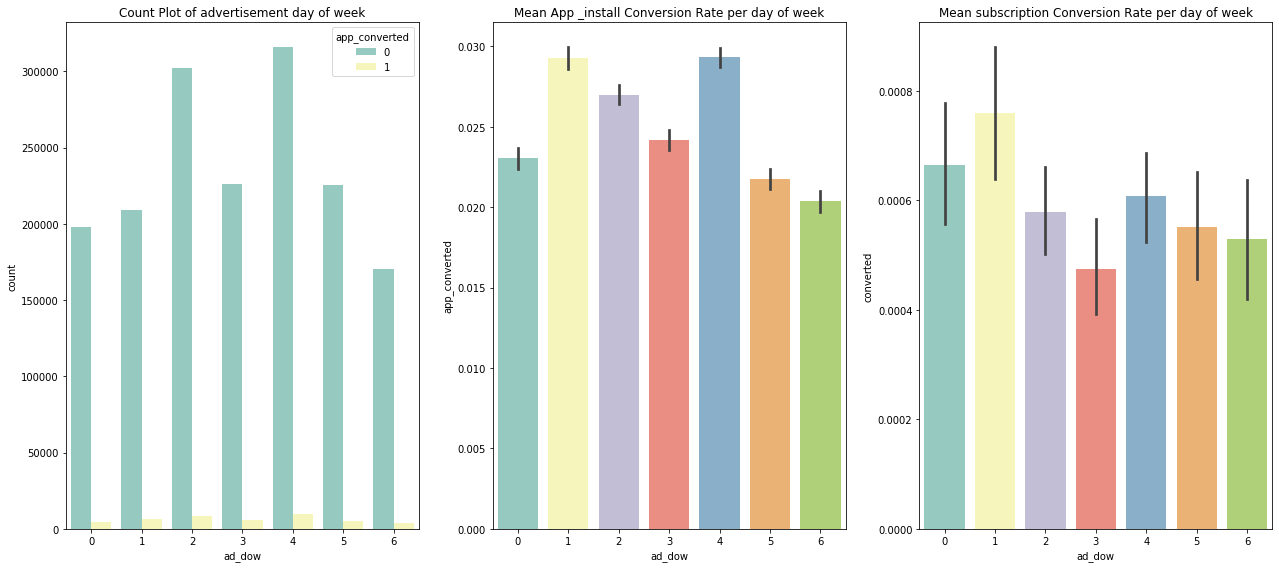

In [36]:
# Visualization of different countries
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='ad_dow', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='ad_dow', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='ad_dow', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean subscription Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

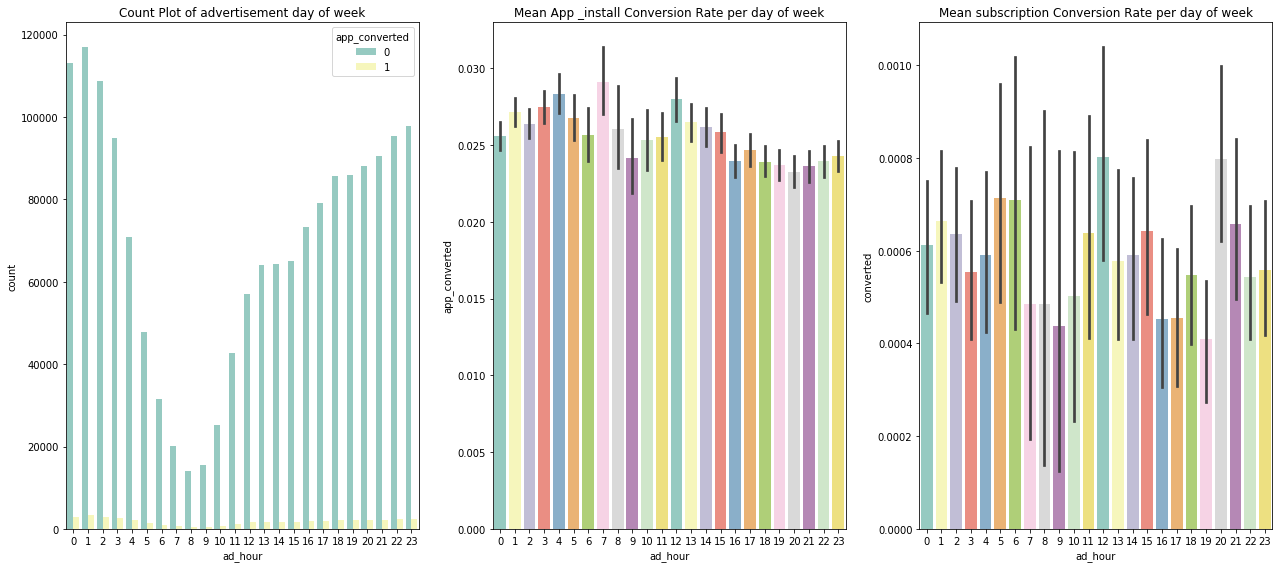

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='ad_hour', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='ad_hour', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='ad_hour', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean subscription Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

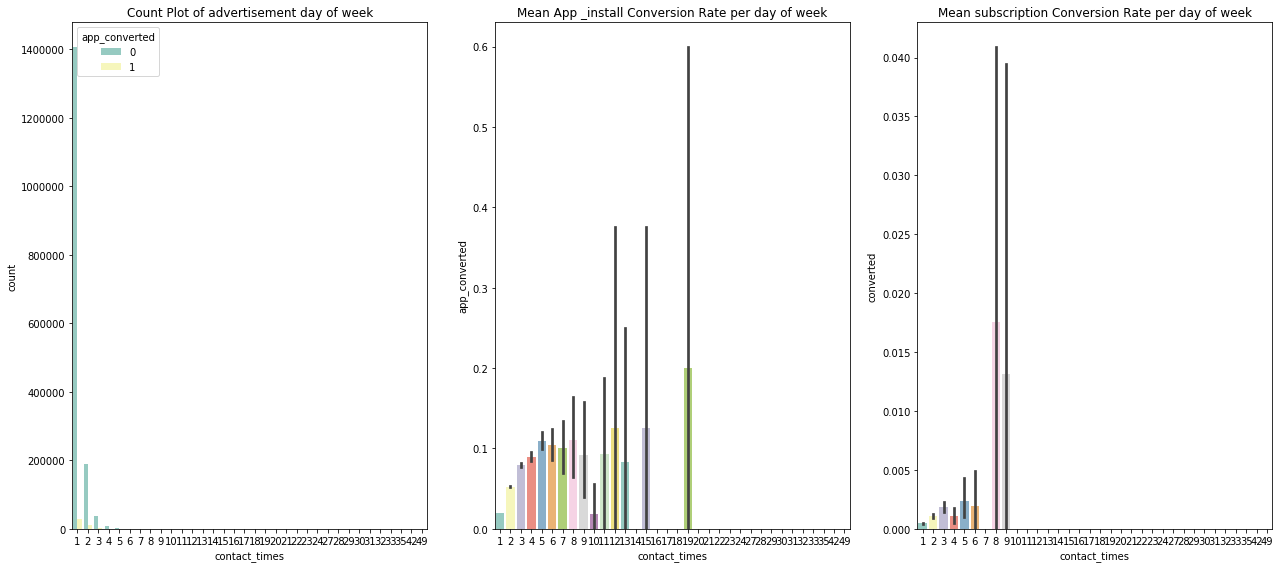

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='contact_times', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='contact_times', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='contact_times', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean subscription Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

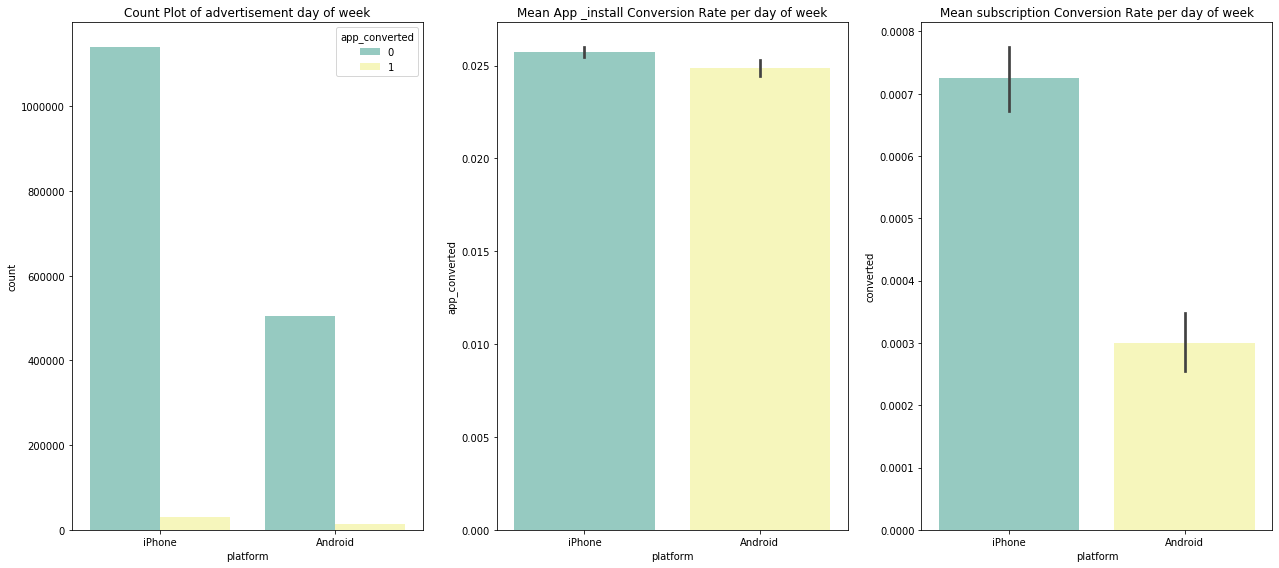

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
sns.countplot(x='platform', hue='app_converted', data=data, ax=ax[0],palette="Set3")
ax[0].set_title('Count Plot of advertisement day of week', fontsize=12)
sns.barplot(x='platform', y='app_converted', data=data, ax=ax[1],palette="Set3");
ax[1].set_title('Mean App _install Conversion Rate per day of week', fontsize=12)
sns.barplot(x='platform', y='converted', data=data, ax=ax[2],palette="Set3");
ax[2].set_title('Mean subscription Conversion Rate per day of week', fontsize=12)
plt.tight_layout()
plt.show()

# Propensity Modeling from ad to app install

In [42]:
data = pd.read_csv('data/data_clean_full.csv')

In [10]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690789 entries, 0 to 1690788
Data columns (total 13 columns):
uid                  1690789 non-null object
ad_dow               1690789 non-null int64
ad_hour              1690789 non-null int64
contact_times        1690789 non-null int64
campaign_name_std    1690789 non-null object
platform             1690789 non-null object
device_id            43080 non-null object
source               43080 non-null object
ai_dow               43080 non-null float64
ai_hour              43080 non-null float64
article_id_std       43080 non-null object
converted            1690789 non-null int64
app_converted        1690789 non-null int64
dtypes: float64(2), int64(5), object(6)
memory usage: 167.7+ MB


In [11]:
data.columns

Index(['uid', 'ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std',
       'platform', 'device_id', 'source', 'ai_dow', 'ai_hour',
       'article_id_std', 'converted', 'app_converted'],
      dtype='object')

In [12]:
features = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std','platform']
target = ['app_converted']

In [13]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_202"; Java(TM) SE Runtime Environment (build 1.8.0_202-b08); Java HotSpot(TM) 64-Bit Server VM (build 25.202-b08, mixed mode)
  Starting server from /Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tx/w31syby511q037fpz5102mbm0000gp/T/tmpvoc4sxrw
  JVM stdout: /var/folders/tx/w31syby511q037fpz5102mbm0000gp/T/tmpvoc4sxrw/h2o_dwightliu_started_from_python.out
  JVM stderr: /var/folders/tx/w31syby511q037fpz5102mbm0000gp/T/tmpvoc4sxrw/h2o_dwightliu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_dwightliu_k19r5b
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [14]:
df = data[features+target].copy()

In [15]:
h2o_df = H2OFrame(df)
h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,ad_dow,ad_hour,contact_times,campaign_name_std,platform,app_converted
type,int,int,int,enum,enum,int
mins,0.0,0.0,1.0,,,0.0
mean,2.9752127557016212,11.850216673990676,1.197006249744937,,,0.025479228928033008
maxs,6.0,23.0,49.0,,,1.0
sigma,1.8539350044923615,7.932310187374041,0.5578237544668238,,,0.15757554539568802
zeros,202885,116070,0,,,1647709
missing,0,0,0,0,0,0
0,4.0,0.0,1.0,author_88,iPhone,0.0
1,4.0,0.0,1.0,non_top_ten,iPhone,0.0
2,4.0,0.0,1.0,author_88,iPhone,0.0


In [ ]:
# Split into 80% training and 20% test dataset
h2o_df['app_converted'] = h2o_df['app_converted'].asfactor()
strat_split = h2o_df['app_converted'].stratified_split(test_frac=0.2, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std','platform']
target = 'app_converted'

In [17]:
# Build random forest model
rf = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                seed=1, score_each_iteration=True)
rf.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


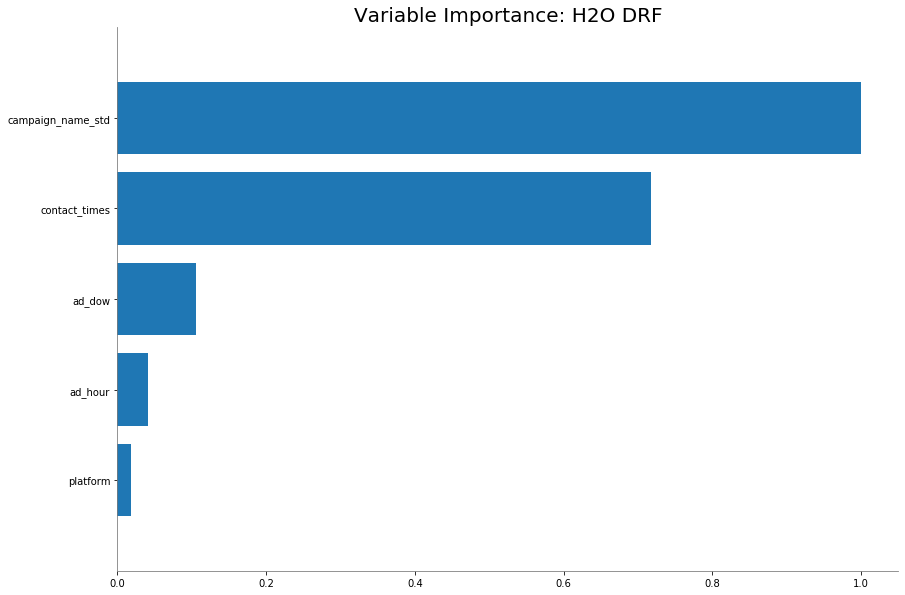

In [18]:
rf.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


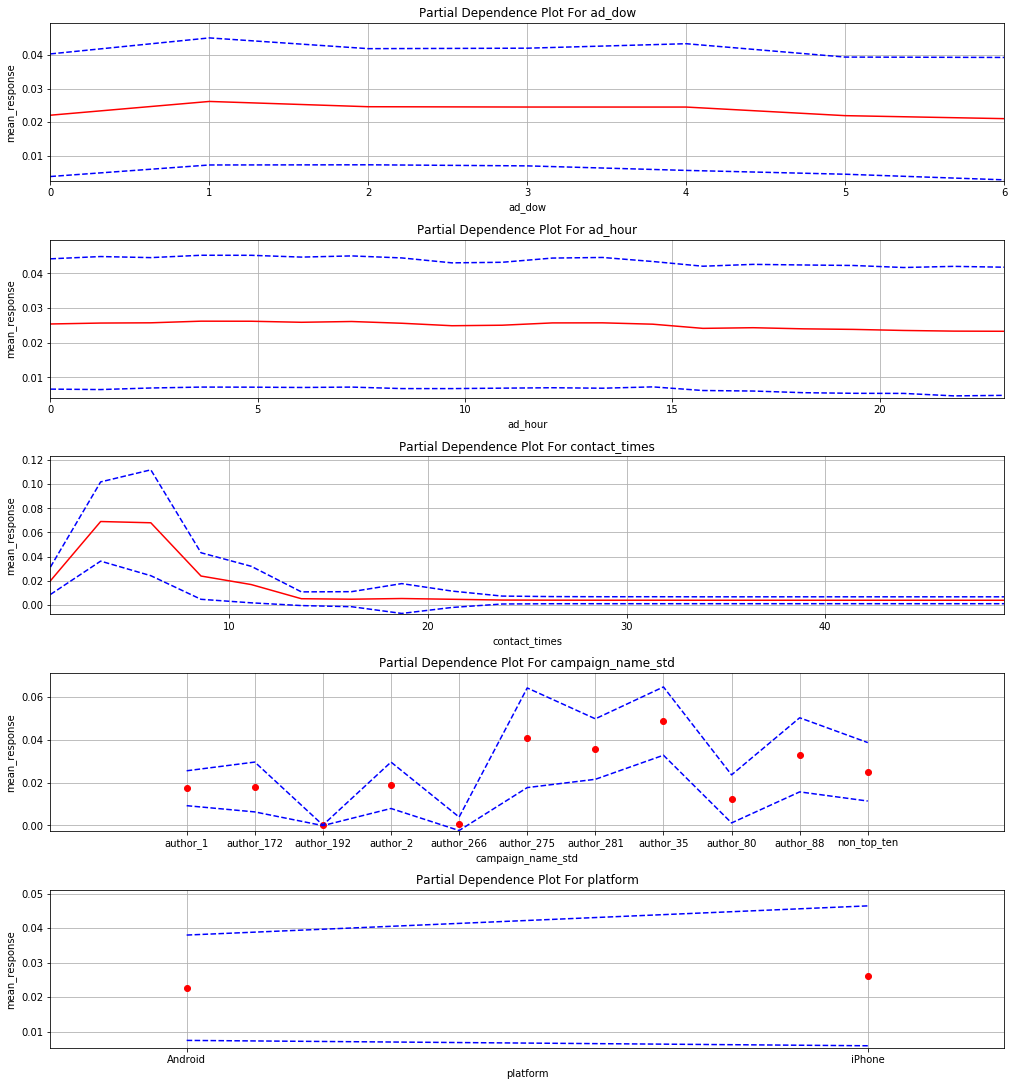

In [19]:
_ = rf.partial_plot(train, cols=feature, figsize=(14, 15))

# Business Insight

## from paid ad to app install, we canstrategies priority based on the feature importance, 
### 1.campaign_name is the most influential feature: with the partial dependence plot, we know that author 35,author 275 has higher chance to convert, we can suggest marketing team to promote these two authors,
### however like author 192 and 266, I'd suggest team to dig into two direction, fully understand the taste of audience we recommend to, and suggest the author that how the customer respond to the content.
### 2. contact times: We can see taht < 7 times, the propensity of audience will increase with contact times, however > 7, the propensity decrease, therefore,
### I'd suggest the marketing, don't recommend the audience more than 7 times in one month. And it also save some budget. Or we can consider another strgety like providing promo code to the customers we already contact for 7 times.
### 3.advertisement day of week: Tuesday and Friday, I'd suggest invest more money in ad on these two days, however, on the weekends, the conversion rate is getting less, we need to dig into backgroun of customers, probably it's different type of customers, make sure how weekends customers differ from the weekday customers, either in age, location, or browsing behavior inorder to understand why they converted less
### 4.platform: I will check whehter the is difference between iOS and Android customer especially demorgraphic. If platform is a driving factor, I will check the consistency between adtertisement visualization between iOS and Android.

# Propensity Modeling from ad to paid subscribe

In [46]:
need_cols = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std',
    'platform', 'source', 'ai_dow', 'ai_hour',
    'article_id_std', 'converted', 'app_converted']
data = data[need_cols].copy()
data = data[data['app_converted'] == 1].copy()

In [47]:
data = data.drop(['app_converted'],axis=1)

In [23]:
data.head()

,ad_dow,ad_hour,contact_times,campaign_name_std,platform,source,ai_dow,ai_hour,article_id_std,converted
12,4,0,1,author_88,iPhone,facebook_ads,4.0,0.0,3172,0
18,4,0,1,author_88,iPhone,facebook_ads,4.0,0.0,3172,0
36,4,0,4,author_88,iPhone,facebook_ads,4.0,0.0,3172,0
37,4,0,4,author_88,iPhone,facebook_ads,4.0,0.0,3172,0
87,4,0,2,author_88,Android,facebook_ads,4.0,0.0,3172,0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43080 entries, 12 to 1690786
Data columns (total 10 columns):
ad_dow               43080 non-null int64
ad_hour              43080 non-null int64
contact_times        43080 non-null int64
campaign_name_std    43080 non-null object
platform             43080 non-null object
source               43080 non-null object
ai_dow               43080 non-null float64
ai_hour              43080 non-null float64
article_id_std       43080 non-null object
converted            43080 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 3.6+ MB


In [25]:
features = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std',
    'platform', 'source', 'ai_dow', 'ai_hour',
    'article_id_std']
target = ['converted']

In [26]:
df = data[features+target].copy()

In [27]:
h2o_df = H2OFrame(df)
h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,ad_dow,ad_hour,contact_times,campaign_name_std,platform,source,ai_dow,ai_hour,article_id_std,converted
type,int,int,int,enum,enum,enum,int,int,enum,int
mins,0.0,0.0,1.0,,,,0.0,0.0,,0.0
mean,2.887465181058502,11.478899721448487,1.5081244196843127,,,,2.828946146703836,11.602506963788278,,0.023351903435468894
maxs,6.0,23.0,19.0,,,,6.0,23.0,,1.0
sigma,1.7812575502860493,7.91334427796891,0.8628285431367911,,,,1.7553710221241028,7.887591690597997,,0.15102026835702542
zeros,4676,2968,0,,,,4486,2795,,42074
missing,0,0,0,0,0,0,0,0,0,0
0,4.0,0.0,1.0,author_88,iPhone,facebook_ads,4.0,0.0,3172,0.0
1,4.0,0.0,1.0,author_88,iPhone,facebook_ads,4.0,0.0,3172,0.0
2,4.0,0.0,4.0,author_88,iPhone,facebook_ads,4.0,0.0,3172,0.0


In [28]:
# Split into 80% training and 20% test dataset
h2o_df['converted'] = h2o_df['converted'].asfactor()
strat_split = h2o_df['converted'].stratified_split(test_frac=0.2, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

#feature = ['city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model',
          #'vehicle_year','day_of_week','is_weekend','is_bgc','vehicle_age']
feature = features = ['ad_dow', 'ad_hour', 'contact_times', 'campaign_name_std',
    'platform', 'source', 'ai_dow', 'ai_hour',
    'article_id_std']
target = 'converted'

In [29]:
# Build random forest model
rf = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                seed=1, score_each_iteration=True)
rf.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


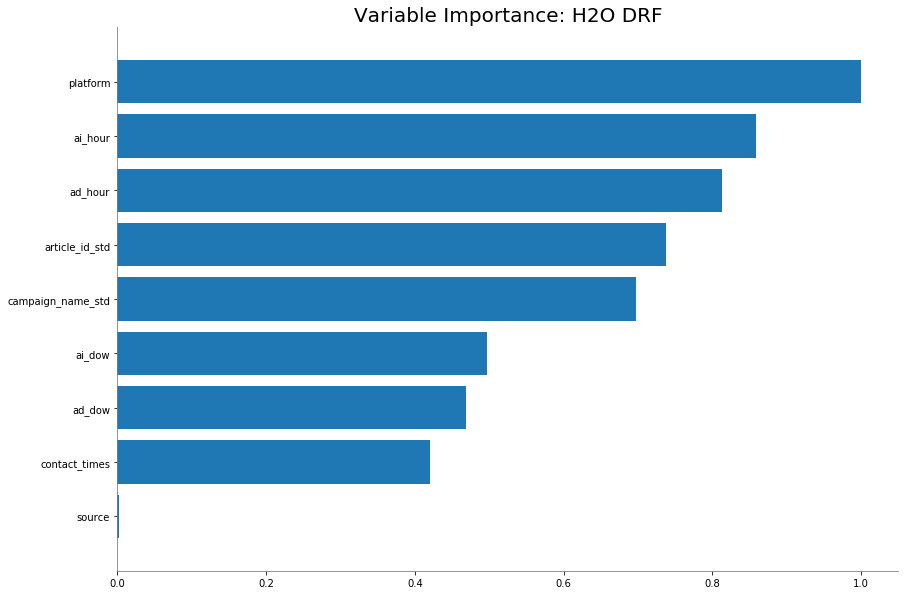

In [30]:
rf.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


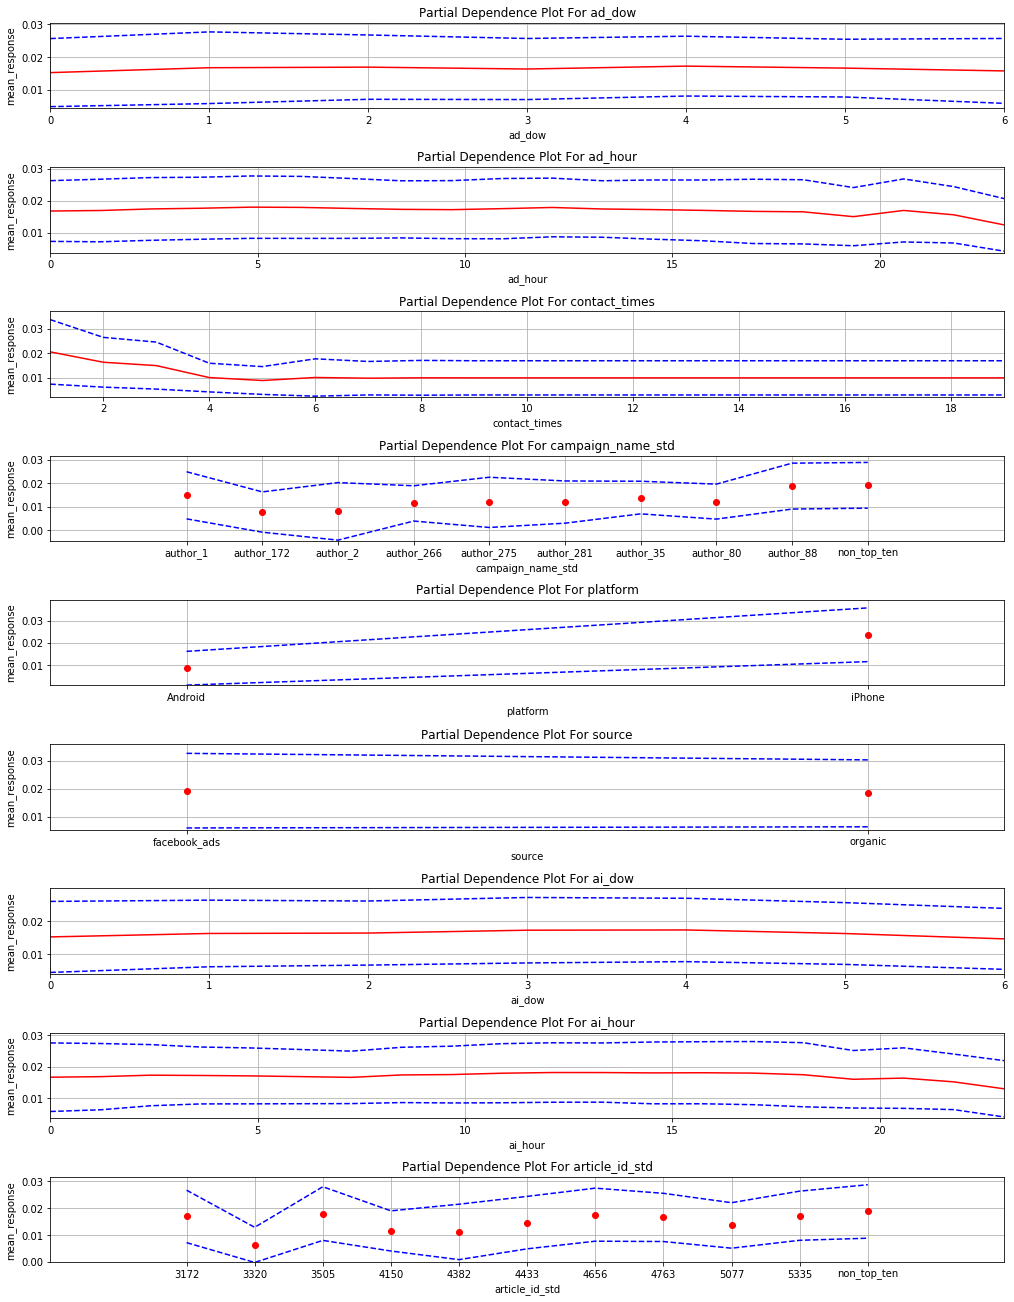

In [53]:
_ = rf.partial_plot(train, cols=feature, figsize=(14, 18))

## from paid ad to subscription, we canstrategies priority based on the feature importance, 
### 1.platform is the most influential feature: This is very common in real world case, there are two situations: 
### (a)We need to dig into how different the background of iphone and android customerm, usually it correlates with US, or Non-US becasue the apple product market share is much higher in the US, the English is their main language, that's why this app product is more suitable for Native customers.
### (b)If platform is the factor, it means Android app is worse thatn iOS app, and I would check consistency between iOS and Android app. 
### 2. app install hour of the day: I would suggest we could remind customer to download and void the hour 20-24. There are two situations (a) the customers during the midningt has different behavior, therefore we need to understand why they haven't finished the download,whehter the app visualization tends to look unclear in the dark
### (b) We can also check the system performance during 20-24, whether the app store, and google play usually have conduct maintenance and it lower the subscription rate.
### 3.advertisement hour of day: I'd suggest invest more money in ad during daytime, and check why after hour 20, the subscription rate decrease. is it due to the different customers or the same advertisement will look different during daytime or nighttime
### 4. article_id: we can see that non_top_ten is the baseline, however I'd like to check the content like 3320,4382 because the modeling result told me these two articles tends to drive customers convert less. 
### 5. campaign_name: we can see that non_top_ten is the baseline, however I'd like to the author like author_2 and author_172 why their audience tends to convert less. Is it due to the recommendation model or the advertisement visualization 

# Summary:
### If we consider more about the brand awareness, I would apply the first modeling results because it focus more on the advertisement side
### If we care more about revenue, I would apply the second modeling results becaseu it targets at more quality customer with high propensity of buscription which is tight related to the company revenue performance.

# If I have more time, I'd like to discuss:
### 1. this data is approxamately one month, I would like to know the data with longer time frame and this can help me to capture seasonality component and modeling results will become more stable
### 2. I'd like to know how the article id is generated because it seems like it's not random, is it classified based on the topic or category?
### 3. If we would like to fucos more on the content straty, it's better to get the content data, like text caption and I can analyze the content pattern, and its similarity between different author.